# Natural Language Processing With Scapy Library for Python

This notebook starts by using [PRAW](https://praw.readthedocs.io/en/latest/#), "The Python Reddit API Wrapper" which will be used to download comments from the subreddit [r/news/](https://www.reddit.com/r/news/).

PRAW can be used to create chat bots on reddit or just to scrap data from it to gain insights into online social media. I will use to [Scapy](https://scapy.readthedocs.io/en/latest/introduction.html) to then perform natural language processing since this python library already have pretain models for this task.

We will try to create an algorithm to detect online harassment, and in particular to flag if a comment has a high likihood of contain hate speech.

# Import Libraries

In [342]:
import spacy
import praw
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Reddit PRAW

Go to this [page](https://www.reddit.com/prefs/apps) to create an app on Reddit's API page.


Rules for Reddits API can be found [here](https://github.com/reddit-archive/reddit/wiki/API).

Instructions for creating Reddit app below have been taken from [Felippe Rodrigues's](https://www.storybench.org/how-to-scrape-reddit-with-python/) post from [storybench.org](https://www.storybench.org/)

![image](https://www.storybench.org/wp-content/uploads/2018/03/Screen-Shot-2018-02-28-at-5.37.01-PM.png)

This form should open up:
![image](https://www.storybench.org/wp-content/uploads/2018/03/Screen-Shot-2018-02-28-at-6.55.38-PM.png)

Pick a name for your application and add a description for reference. Also make sure you select the “script” option and don’t forget to put http://localhost:8080 in the redirect uri field. If you have any doubts, refer to [Praw documentation](https://praw.readthedocs.io/en/latest/getting_started/authentication.html#script-application).

Hit create app and now you are ready to use the OAuth2 authorization to connect to the API and start scraping. Copy and paste your 14-characters personal use script and 27-character secret key somewhere safe. You application should look like this:

![image](https://www.storybench.org/wp-content/uploads/2018/03/Screen-Shot-2018-02-28-at-7.02.45-PM.png)

It is important to note below that the values in the fields `client_id`, `client_secret`, `user_agent`, `username`, and `password` need to be replaced with ones own from the reddit API. Below I have a reddit.json file in my parent directory and read values from this file which are fed into the `praw.Reddit()` function.

In [2]:
id_ = ''
secret_ = ''
agent_ = ''
username_ = ''
password_ = ''

with open('../reddit.json', 'r') as file:
    lines = json.load(file)
    id_ += lines['client_id']
    secret_ += lines['client_secret']
    agent_ += lines['user_agent']
    username_ += lines['username']
    password_ += lines['password']

In [3]:
reddit = praw.Reddit(client_id=id_,
                     client_secret=secret_,
                     user_agent=agent_,
                     username=username_,
                     password=password_)

## [r/news/](https://www.reddit.com/r/news/) subreddit.

The subreddit of interest is `r/news/` though one can edit the first line the cell below to change what subreddit to look at. We will only be looking at one article in this subreddit name

In [4]:
subreddit = reddit.subreddit('news')
top_subreddit = subreddit.top(limit=10)

In [5]:
topics_dict = {"title":[], "score":[], "id":[], "url":[], "comms_num": [], "created": [], "body":[]}
for n in top_subreddit:
    topics_dict["title"].append(n.title)
    topics_dict["score"].append(n.score)
    topics_dict["id"].append(n.id)
    topics_dict["url"].append(n.url)
    topics_dict["comms_num"].append(n.num_comments)
    topics_dict["created"].append(n.created)
    topics_dict["body"].append(n.selftext)

In [6]:
df = pd.DataFrame.from_dict(topics_dict)

In [7]:
df.head()

,title,score,id,url,comms_num,created,body
0,Blizzard Employees Staged a Walkout After the ...,226324,dfn3yi,https://www.thedailybeast.com/blizzard-employe...,9608,1.570683e+09,
1,President Donald Trump says he has tested posi...,226039,j3oj21,https://www.cnbc.com/2020/10/02/president-dona...,34774,1.601644e+09,
2,Kobe Bryant killed in helicopter crash in Cali...,213681,eubjfc,https://www.fox5dc.com/news/kobe-bryant-killed...,20656,1.580096e+09,
3,Scientist Stephen Hawking has died aged 76,188176,84aebi,http://news.sky.com/story/scientist-stephen-ha...,6913,1.521028e+09,
4,Jeffrey Epstein's autopsy more consistent with...,186243,dp5lr1,https://www.foxnews.com/us/forensic-pathologis...,10043,1.572465e+09,


In [8]:
submission = reddit.submission(id="eubjfc")
submission.comment_sort = "new"
len(submission.comments.list())

294

We will only look at one article to inspect if there is hate speech since this article alone has over 20,000 comments and will take time for my computer to process, I will limit PRAW to 'scrolling' down the page to load more comments with the `limit=99` parameter. In the cell below I am initializing a dictionary which to append values into each key which will be used to create a pandas dataframe.

In [9]:
comments_dict = {"author":[], "score":[], "id":[], "replies":[], "edited": [], "created": [], "body":[]}

submission.comments.replace_more(limit=99)
for comment in submission.comments.list():
    comments_dict["author"].append(comment.author)
    comments_dict["score"].append(comment.score)
    comments_dict["id"].append(comment.id)
    comments_dict["replies"].append(comment.replies)
    comments_dict["edited"].append(comment.edited)
    comments_dict["created"].append(comment.created_utc)
    #body_ = comment.body.replace
    comments_dict["body"].append(comment.body)

In [10]:
df_ = pd.DataFrame.from_dict(comments_dict)

In [11]:
df_.head(2)

,author,score,id,replies,edited,created,body
0,hoosakiwi,1,ffnzwqh,(),1.58007e+09,1.580073e+09,Let's try and keep the comments here civil. Yo...
1,randy88moss,1,fx335fo,(),False,1.594030e+09,"Thinking about you, Mamba!"


In [12]:
txt = ''
for n in df_['body'].values:
    n = n.replace("\n","").strip()
    txt +=n

In [13]:
txt

'Let\'s try and keep the comments here civil. You don\'t have to like Kobe, but celebrating his death, making jokes about it, and wishing death/threatening other people still violates our rules. Users who threaten other people will be banned on sight.Thinking about you, Mamba!R.I.P. It’s halfway through 2020 and it only really hit me that he’s gone. i didn’t even know you but you still hold a special place in my heart. i hope you, Gigi and the other passengers all have a nice stay in heaven. 😔Maybe myMind just doesn’t have KobeI like how this post got made me smile awards and wholesome awards from peoplePress F to pay respectsFSo did other people. Not hating. But, why only Kobe Mentioned? It’s horrible that anyone died in that accident. Including Kobe. But, honestly bothers me that no one mentions the others involved. Imagine being their family members. Only hearing about Kobe. Must be so hard on them.I still just can’t believe he’s goneanyone else think he was targeted?Zeynel ich fick

### Frequency Counter

We can now start to use natural language processing to counter the frequency of the words occuring the text above. Words which appear more often can tell us if the title of the news article, "Kobe Bryant killed in helicopter crash in California" matches the content of comments. 

Then we will continue to create a model to predict if a comment is hate full speech or not.

In [14]:
nlp = spacy.load("en_core_web_sm")

all_comments = nlp(txt)
words = [chunk.text for chunk in all_comments if not chunk.is_stop and not chunk.is_punct]

In [27]:
comment_counts = Counter(words)

In [54]:
comment_counts.most_common(10)

[('Kobe', 1160),
 (' ', 1116),
 ('people', 772),
 ('like', 739),
 ('daughter', 577),
 ('helicopter', 556),
 ('know', 531),
 ('basketball', 450),
 ('family', 364),
 ('time', 363)]

### Lemmatization

From [Wikipedia](https://en.wikipedia.org/wiki/Lemmatisation),

>Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

For example, organizes, organized and organizing are all forms of organize. Here, organize is the lemma. The inflection of a word allows you to express different grammatical categories like tense (organized vs organize), number (trains vs train), and so on. Lemmatization is necessary because it helps you reduce the inflected forms of a word so that they can be analyzed as a single item. It can also help you normalize the text.

spaCy has the attribute lemma_ on the Token class. This attribute has the lemmatized form of a token:

In [32]:
lemmas = [txt.lemma_ for txt in all_comments if not txt.is_stop and not txt.is_punct]

In [53]:
lemma_counts = Counter(lemmas)
lemma_counts.most_common(10)

[('Kobe', 1159),
 (' ', 1116),
 ('like', 808),
 ('daughter', 806),
 ('people', 782),
 ('know', 742),
 ('helicopter', 735),
 ('die', 589),
 ('say', 556),
 ('go', 514)]

We still have the issue of a space value being the second most common word in the comments text

### Preprocess Text

In [48]:
def is_token_allowed(token):
    '''
     Only allow valid tokens which are not stop words
     and punctuation symbols.
    '''
    if (not token or not token.string.strip() or token.is_stop or token.is_punct):
        return False
    return True

def preprocess_token(token):
    # Reduce token to its lowercase lemma form
    return token.lemma_.strip().lower()


In [52]:
text_processed = [preprocess_token(txt) for txt in all_comments if is_token_allowed(txt)]
text_processed_counter = Counter(text_processed)
text_processed_counter.most_common(10)

[('kobe', 1320),
 ('people', 845),
 ('daughter', 809),
 ('like', 808),
 ('helicopter', 743),
 ('know', 742),
 ('die', 589),
 ('say', 556),
 ('go', 514),
 ('basketball', 487)]

We see an improvement above as we have gotten rid of the space value showing as the second most common word in the previous two frequency counters.  
Though we can only visually inspect if the comments are related to the article heading, we will move on to creating a machine learning model to predict if a comment is hateful or not.

# Clean Train Data

Text data used for this classification problem is from a [GitHub repository](https://github.com/t-davidson/hate-speech-and-offensive-language) for the [paper](https://arxiv.org/abs/1703.04009) "Automated Hate Speech Detection and the Problem of Offensive Language", ICWSM 2017. Dataset was created as described by the paper:

>We begin with a hate speech lexicon containing words and phrases identified by internet users as hate speech, compiled by Hatebase.org... Workers were asked to label each tweet as one of three categories: hate speech, offensive but not hate speech, or neither offensive nor hate speech. They were provided with our definition along with a paragraph explaining it in further detail. Users were asked to think not just about the words appearing in a given tweet but about the context in which they were used. They were instructed that the presence of a particular word, however offensive, did not necessarily indicate a tweet is hate speech. Each tweet was coded by three or more people.

We will use this dataset to create a supervised machine learning model to predict the classifcation of the text in a reddit comment.

In [240]:
df_twitter = pd.read_csv('labeled_data.csv')

In [241]:
df_twitter.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


The tweet column above has a lot of formating issues to be fed into a ML model. Since tweets can be nested we need to clean up the tweets a bit. A rudimentary fix has been made below but more time spent cleaning up the data will create a better model down the road.

In [242]:
df_twitter['tweet'] = df_twitter['tweet'].str.replace('&amp;','and').str.strip('! RT')

In [243]:
df_twitter.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,@mayasolovely: As a woman you shouldn't compla...
1,1,3,0,3,0,1,@mleew17: boy dats cold...tyga dwn bad for cuf...
2,2,3,0,3,0,1,@UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ...
3,3,3,0,2,1,1,@C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,@ShenikaRoberts: The shit you hear about me mi...


In [232]:
hate_speech = round(len(df_twitter[df_twitter['class']==0])/len(df_twitter)*100,2)
off_speech = round(len(df_twitter[df_twitter['class']==1])/len(df_twitter)*100,2)
neither_speech = round(len(df_twitter[df_twitter['class']==2])/len(df_twitter)*100,2)

print('The ratio of Hate Speech labelled rows to total rows is {}%\n\
The ratio of Offensive Speech labelled rows to total rows is {}%\n\
The ratio of Neutral labelled rows to total rows is {}%'.format(hate_speech,off_speech,neither_speech))

The ratio of Hate Speech labelled rows to total rows is 5.77%
The ratio of Offensive Speech labelled rows to total rows is 77.43%
The ratio of Neutral labelled rows to total rows is 16.8%


In [246]:
len(df_twitter)

24783

Since the encoding the tweets into a bag of words takes a VERY long time on my computer I will reduce the size of this data set while keeping the ratio of the three classes of speeches constant.

In [250]:
class_zero = df_twitter[df_twitter['class']==0][:143] # Hate Speech
class_one = df_twitter[df_twitter['class']==1][:1919] # Offensive Language
class_two = df_twitter[df_twitter['class']==2][:416] # Neither

In [252]:
df_twitter = pd.concat([class_zero, class_one, class_two])

Below the Twitter data will be split into a training set and a test set with 1/4 of dataset going to the test set. This will allow how to validate the hatespeech model before moving on to a harder dataset, for example Reddit or any other online source.

In [254]:
X_train, X_test, Y_train, Y_test = train_test_split(df_twitter['tweet'], df_twitter['class'], test_size=0.25, random_state=42)

Now the training text will be concatenated into one large string so we can use the `LabelBinarizer()` function from scikit-learn.

In [257]:
twitter_text_train = ''
for n in X_train:
    twitter_text_train += n + ' '

In [70]:
"""
twitter_text_test = ''
for n in X_test:
    twitter_text_test += n + ' '
"""

In [258]:
twitter_encoder = LabelBinarizer()
twitter_encoder.fit(twitter_text_train.split())

LabelBinarizer()

In [259]:
col_list = range(len(twitter_encoder.classes_)) # columns from classes create from LabelBinarizer
train_list = np.empty((len(X_train),len(twitter_encoder.classes_))) #create empty arrays to populate
test_list = np.empty((len(X_test),len(twitter_encoder.classes_)))

In [266]:
for i, n in enumerate(X_train,0):
    transformed = twitter_encoder.transform(n.split())
    tmp_ = transformed.sum(axis=0).T
    train_list[i] = tmp_
    if i % 200 == 199:
        print(i+1)

200
400
600
800
1000
1200
1400
1600
1800


In [268]:
for i, n in enumerate(X_test,0):
    transformed = twitter_encoder.transform(n.split())
    tmp_ = transformed.sum(axis=0).T
    test_list[i] = tmp_
    if i % 100 == 99:
        print(i+1)

100
200
300
400
500
600


In [ ]:
Twitter_test_df = pd.DataFrame(columns=col_list)
for n in X_test:
    transformed = twitter_encoder.transform(n.split())
    tmp_ = pd.DataFrame(transformed)
    tmp_ = tmp_.sum(axis=0)
    tmp_ = pd.DataFrame(tmp_).T
    #pd.concat([Twitter_test_df, tmp_], axis=1, join='inner')
    Twitter_test_df = Twitter_test_df.append(tmp_, ignore_index=True)

In [269]:
Twitter_train_df = pd.DataFrame(train_list)
Twitter_test_df = pd.DataFrame(test_list)

In [270]:
Twitter_train_df.to_csv('train_list.csv', index=False)
Twitter_test_df.to_csv('test_list.csv', index=False)

In [304]:
Twitter_test_df = Twitter_test_df.reindex(columns = Twitter_train_df.columns, fill_value=0)

# Dimension Reduction

In [ ]:
twitter_text = nlp(twitter_text)
text_processed = [preprocess_token(txt) for txt in twitter_text if is_token_allowed(txt)]

# Predict if Comment is Hateful or Not

In [320]:
lr = LogisticRegression()
lr_fit = lr.fit(Twitter_train_df,Y_train)

In [321]:
lr_fit.score(Twitter_test_df,Y_test)

0.8451612903225807

In [340]:
from sklearn.metrics import plot_confusion_matrix

## Confusion Matrix

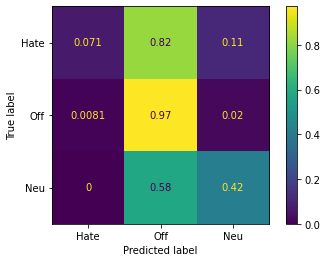

In [356]:
labels = ['Hate','Off','Neu']
plot_confusion_matrix(lr_fit, Twitter_test_df, Y_test, normalize='true', display_labels = labels)
plt.show()